   # **ACCOUNTANT CHATBOT**

**Motivation**

Legal illeteracy or unawareness is a quite common phenomenon in India (especially among Urban Indians). This phenomenon extends to even very basic laws like income tax, which impact day to day life of everyone. For major tasks like IT returns, people resort to Chartered Accountants (CA). But even when they have minor doubts, they had to search among two major legislations, each with around 300 sections, and several small legislations.

# Introduction

**Approach**

With the growing capability of understanding language and generating text by computers, I tried to solve this issue by creating a Question Answer Model, that can answer any query of user regarding Income Tax.

**How can we do that ?**

Existing LLMs have made our life simple by solving many of our generic problems. But when these LLMs were asked a question which is very specific to certain domain, they hallucinate, and give very random/generic answers. This is the case with even the state of art models like GPT or LLama.

So these LLMs directly might not solve our problem, because our issue is also very specific to domain knowledge.


**What are alternatives?**

We have two alternatives for this

1. Changing the LLM according to our use case (Chnaging atleast one parameter of LLM).
2. Giving LLM the repestive context (wrt query),and extracting the answer from it in format we want.

The technique we can use, to achieve case-1 is called finetuning.

**Can we Use Fine-tuning for our case?**

1. Fine-tuning is an ideal case to solve our problem, but changing the parameters of an LLM according to our case is computationally very costly process. 
2. We can't keep on fine-tuning our model everytime we have an ammedment in respective Laws.

So before delving into finetuning, we can explore the other computationally cheaper technique.

**Retrieval Augmentation Generation (RAG)**

RAG is a frame work of retrieving information/knowledge from external source to add a context for LLM to answer relevant queries.

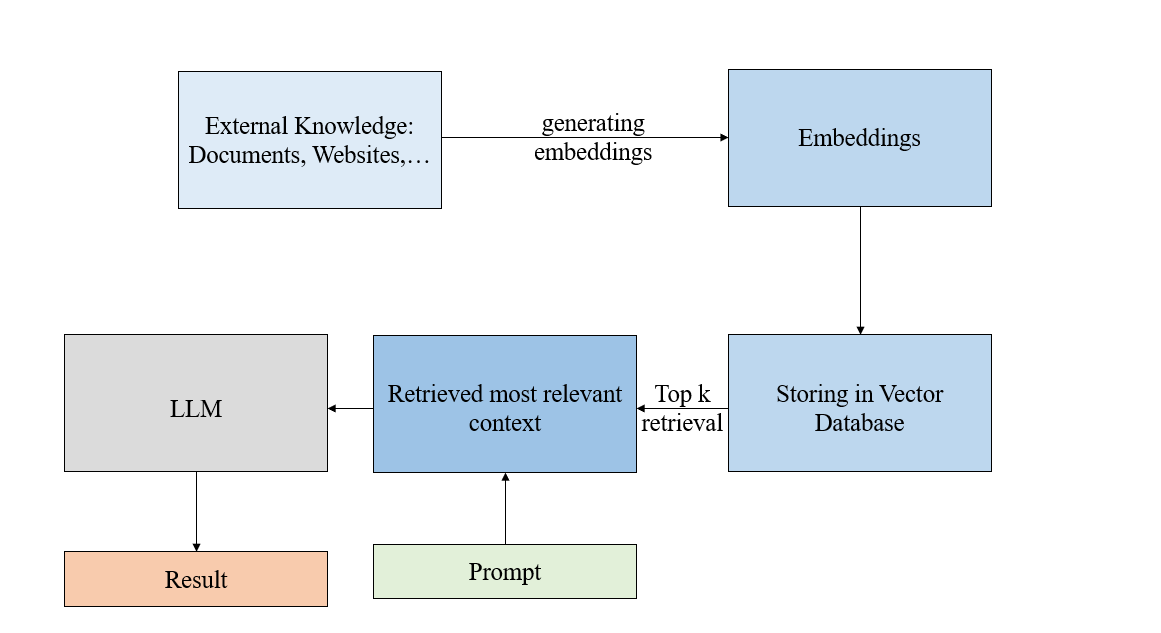

# Index

**The Whole process of generating answers through RAG system has these steps**

* **Initialisation**

* **Ingestion**
    
* **Retrieval**

* **Synthesis**


# Initialisation

In [2]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import transformers
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet

!pip install unstructured --quiet
!pip install sentence-transformers --quiet


!pip install gradio --quiet
!pip install xformer --quiet

In [6]:
import torch
# import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

In [7]:
from transformers import AutoModelForCausalLM 
# AutoTokenizer, GenerationConfig, pipeline

# 1. INGESTION

Ingestion is the formal first step of RAG

It includes all steps prior to Retrieval i.e.,

1. Document Extraction
2. Splitting & Chunking
3. Vectorize (Assign Embeddings to chunks)
4. Indexing (Storing all these vectors into Vectorstore)

## 1.1 Document Extraction

We are extracting information from existing pdfs of Income Tax Laws and CA textbooks from ICAI official website

Pypdf is used for extraction

It has limitations in

*  Handling text in images

*  Handling tables

We can proceed with it, if we don't have these limitations

In [8]:
from langchain.document_loaders import PyPDFLoader

In [9]:
loader = PyPDFLoader("/kaggle/input/income-tax/Heads of Income.pdf")
data_1 = loader.load_and_split()

In [10]:
loader = PyPDFLoader("/kaggle/input/income-tax/Aggregation of Income setoff and carry forward of losses.pdf")
data_2 = loader.load_and_split()

In [11]:
loader = PyPDFLoader("/kaggle/input/income-tax/Aggregation of Total Income.pdf")
data_3 = loader.load_and_split()

In [12]:
loader = PyPDFLoader("/kaggle/input/income-tax/Basic Concepts.pdf")
data_4 = loader.load_and_split()

In [13]:
loader = PyPDFLoader("/kaggle/input/income-tax/Deduction from Gross total income.pdf")
data_5 = loader.load_and_split()

In [14]:
loader = PyPDFLoader("/kaggle/input/income-tax/Income of other persons included in assesse total income.pdf")
data_6 = loader.load_and_split()

In [15]:
loader = PyPDFLoader("/kaggle/input/income-tax/Residence and scope of total income.pdf")
data_7 = loader.load_and_split()

In [16]:
loader = PyPDFLoader("/kaggle/input/income-tax/IT Act (English)_0.pdf")
data_8 = loader.load_and_split()

## 1.2 Splitting & Chunking

Recursive Character text Splitter is used for splitting the text.

Text splitting is done based on the chunk size, and overlap. Overlap is to not miss the context in between chunks.

Two different text splitters with different chunk size and chunk overlap are defined, where one is for IT laws (since the sections of IT law can be smaller, and we can't miss those in the context), another is for textbooks.



In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter_1 = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=50, add_start_index=True
)

In [18]:
text_splitter_2 = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50, add_start_index=True
)

In [19]:
It_law_splits = text_splitter_1.split_documents(data_8)

In [20]:
data_1_splits = text_splitter_2.split_documents(data_1)
data_2_splits = text_splitter_2.split_documents(data_2)
data_3_splits = text_splitter_2.split_documents(data_3)
data_4_splits = text_splitter_2.split_documents(data_4)
data_5_splits = text_splitter_2.split_documents(data_5)
data_6_splits = text_splitter_2.split_documents(data_6)
data_7_splits = text_splitter_2.split_documents(data_7)

## 1.3 Vectorization

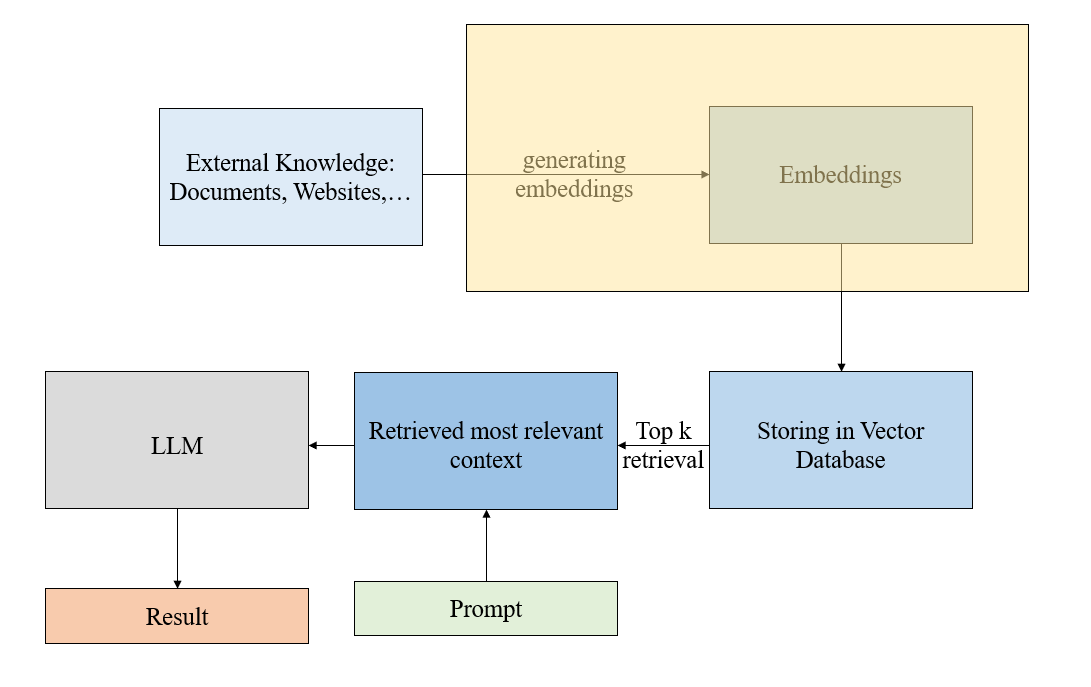

Each of this chunk is converted into vectors using embeddings. 

In our case we have used e5 (EmbEddings from bidirEctional Encoder rEpresentation) for vectorization

More about E5 embeddings: https://arxiv.org/pdf/2212.03533.pdf

In [ ]:
embeddings_2 = HuggingFaceEmbeddings(
    model_name="intfloat/e5-small-v2",
    model_kwargs={'device': 'cuda:0'}
)

For more embeddings, one can look out in mteb leader board of Hugging face

https://huggingface.co/spaces/mteb/leaderboard

## 1.4 Indexing

The next step post vectorizing chunks is storing all these vectors in a vector store. 

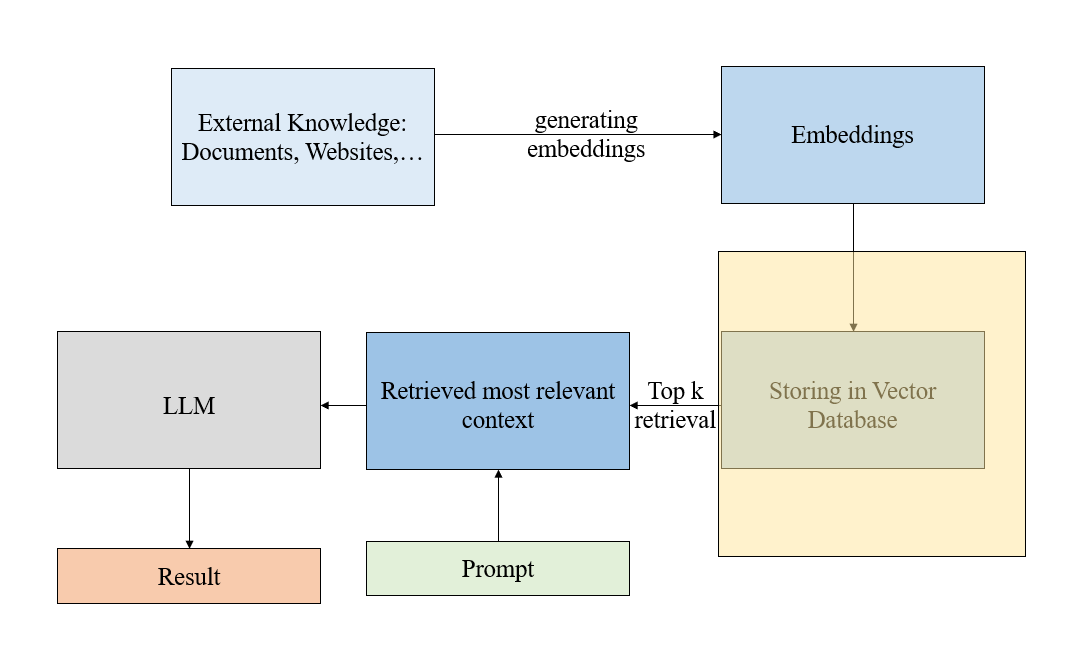

**Why Vector database, why not Relational database?**

* Relational databases are used when the data is structured.
* In case of vector database, a chunk can be retrieved based on the distance between vectors (cosine similarity, eucledian distance...)
* This is not the case with Relational database.


We have used Chroma database for our case.

In [22]:
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=data_1_splits, embedding = embeddings_2)

In [23]:
vectorstore = Chroma.from_documents(documents=data_2_splits, embedding = embeddings_2)
vectorstore = Chroma.from_documents(documents=data_3_splits, embedding = embeddings_2)
vectorstore = Chroma.from_documents(documents=data_4_splits, embedding = embeddings_2)
vectorstore = Chroma.from_documents(documents=data_5_splits, embedding = embeddings_2)
vectorstore = Chroma.from_documents(documents=data_6_splits, embedding = embeddings_2)
vectorstore = Chroma.from_documents(documents=data_7_splits, embedding = embeddings_2)

In [24]:
vectorstore = Chroma.from_documents(documents=It_law_splits, embedding = embeddings_2)

# 2. Retrieval

The immediate step after the Ingestion (storing vectors) is defining the retrieval mechanism.

Here we are using top k retrieval mechanism, where we retrieve the top k closest vectors to the query vector.

(Using these k closest vectors/chunks, answer will be synthesised later).

Due to the small size of chunk size, we have kept the k value to be 15.

In [25]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 15})

# 3. Synthesis

This forms the last step of the RAG

Both the context and query are fed into the LLM to generate the relevant answer

In [26]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

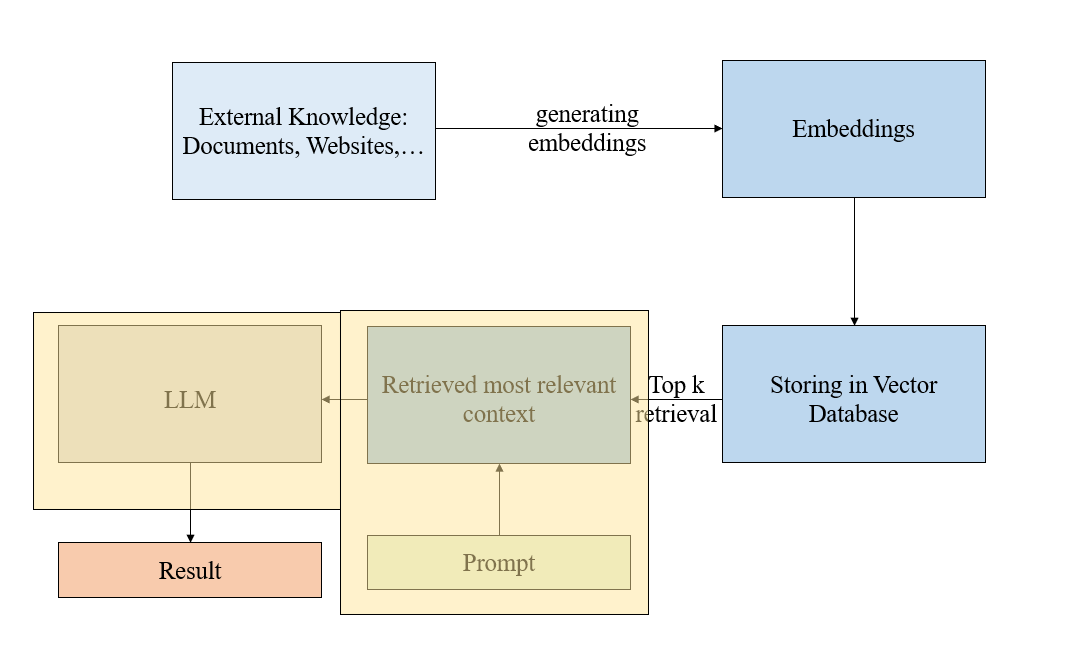

## 3.1 LLM

The LLM chosen is Mistral 7B Instruct

It is chosen mainly becuase of it's inference speed and better performance as compared to it's alternatives (Llama 2 13b)

It's speciality lies in Grouped Query Attention and Sliding Window Attention

Create a Huggingface api key and use it for llm.

In [27]:
import os
os.environ['HUGGINGFACEHUB_API_TOKEN'] = ''

In [28]:
from transformers import GenerationConfig

In [ ]:
# llm = HuggingFacePipeline(
#     pipeline=pipeline,
#     )

In [ ]:
# Define the model name for Mistral-7B-Instruct-v0.1
model_name = 'mistralai/Mistral-7B-Instruct-v0.1'

# Load the model configuration from the pretrained Mistral model
model_config = transformers.AutoConfig.from_pretrained(
    model_name,
)

# Initialize the tokenizer for Mistral-7B-Instruct-v0.1
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Set the padding token to be the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Set the padding side to "right" indicating padding will be applied to the right side of the sequences
tokenizer.padding_side = "right"


In [30]:
# Enable 4-bit quantization
use_4bit = True

# Set the compute data type to float16 for 4-bit quantization
bnb_4bit_compute_dtype = "float16"

# Specify the 4-bit quantization type as "nf4"
bnb_4bit_quant_type = "nf4"

# Disable nested quantization
use_nested_quant = False


In [31]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
)

## Testing LLM on known random question

This is to check if the llm is imported, and is generating the text we want

In [45]:
inputs_not_chat = tokenizer.encode_plus("[INST] Tell me about Gandhi? [/INST]", return_tensors="pt")['input_ids'].to('cuda')

generated_ids = model.generate(inputs_not_chat, 
                               max_new_tokens=1000, 
                               do_sample=True)
answer = tokenizer.batch_decode(generated_ids)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [48]:
print(answer)

["<s> [INST] Tell me about Gandhi? [/INST] Gandhi, also known as Mahatma Gandhi, was a leader in the Indian independence movement against British rule. He is widely regarded as one of the greatest leaders in history due to his philosophy of nonviolent resistance, or civil disobedience, which he used to achieve political and social change. Born on October 2 October 1869 in Porbandar, India, Gandhi received his education in England before returning to India in 1915 to fight for India's independence.\n\nGandhi's approach to resistance was unique in that he believed in peaceful means, such as hunger strikes, peaceful protests, and civil disobedience, to achieve his goals. He believed that violence only begets more violence, and that nonviolent resistance could bring about lasting change. Gandhi's leadership and philosophy helped to lead the Indian independence movement to a successful conclusion in 1947, when India gained its independence from British rule.\n\nGandhi's legacy has been wide

## 3.2 Creating text generation pipeline

In [35]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=300,
)

## 3.3 Prompt

In [36]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [37]:
prompt_template = """
### [INST] 
You are a legal chatbot, you give advice on any question related to Income Tax
If it's not relevant to context, tell that you are not meant to answer that


Use 300 words maximum and keep the answer as concise as possible.

{context}

### QUESTION:
{question} 

Helpful Answer: 



1. According to Section "specify section number"....." Finish the answer.



2. To claim that, you have to follow..... "" Finish the answer
[/INST]
 """

mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Create prompt from prompt template 
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain 
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

## 3.4 Response

In [38]:
answer = llm_chain.invoke({"context":"", 
                  "question": """I'm a 21 year old graduate employee with education loan, where can I claim my taxes?"""})

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### **LLM Generated Answer Without Context**

In [39]:
print(answer['text'])

1. According to Section 64 of the Income Tax Act, 1961, if you are a graduate employee with an education loan, you can claim tax deductions under Section 80E. This allows you to deduct the interest paid on your education loan from your taxable income.
2. To claim this deduction, you will need to file an IT return and provide proof of the interest paid on your education loan, such as bank statements or tax receipts. You should also keep track of the amount of interest paid throughout the year to ensure that you are claiming the full deduction available to you.


### **LLM Generated Answer With Context**

In [40]:
query = """I'm a 21 year old graduate employee with education loan, where can I claim my taxes?"""

retriever = vectorstore.as_retriever()

rag_chain = ( 
 {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

answer = rag_chain.invoke(query)['text']

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [43]:
print(answer)

1. According to Section 22 of the IT Act, the return is accompanied by proof of the tax, if any, claimed to have been deducted or collected at source, and the advance tax and tax on self-assessment, if any, claimed to have been paid. Therefore, as a graduate employee with an education loan, you should include proof of the interest paid on your loan in your income tax return.
2. To claim the deduction for the interest paid on your education loan, you need to file your income tax return and provide proof of the interest paid, such as bank statements or receipts. The deduction is available under Section 80C of the IT Act, which allows for a deduction of up to Rs. 75,000 per year from the total income of an individual for certain types of investments, including education loans.
